In [3]:
import pandas as pd
import os 
import numpy as np
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
current_dir = os.getcwd()
from collections import defaultdict


# Procesamiento y seleccion de datos

### 1 producto, todas las tiendas, para todas las fechas 

In [5]:

# Parámetros
chunk_size = 100_000
total_data_path = os.path.join(current_dir, '../data/raw/total_data.csv')
target_rows = 1_000_000
min_items = 1  # Usar 5 productos por tienda
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

# Paso 1: Obtener fechas únicas
all_dates = set()
for chunk in pd.read_csv(total_data_path, chunksize=chunk_size, usecols=['date']):
    all_dates.update(chunk['date'].unique())
all_dates = sorted(list(all_dates))
D = len(all_dates)
print(f"Total de fechas únicas: {D}")

# Paso 2 y 3: Procesar cada tienda
all_filtered_data = []
for store_id_selected in store_ids:
    print(f"\nProcesando tienda: {store_id_selected}")
    item_date_counts = defaultdict(set)
    sales_by_item = defaultdict(float)

    # Identificar productos y sumar ventas
    for chunk in pd.read_csv(total_data_path, chunksize=chunk_size, usecols=['item_id', 'date', 'store_id', 'sales']):
        chunk['store_id'] = chunk['store_id'].astype(str)
        chunk_filtrado = chunk[chunk['store_id'] == store_id_selected]
        for item, date, sales in zip(chunk_filtrado['item_id'], chunk_filtrado['date'], chunk_filtrado['sales']):
            item_date_counts[item].add(date)
            sales_by_item[item] += sales

    # Filtrar productos que están en todas las fechas
    items_in_all_dates = [item for item, dates in item_date_counts.items() if len(dates) == D]
    if not items_in_all_dates:
        print(f"Ningún producto válido en {store_id_selected}. Se omite esta tienda.")
        continue

    # Seleccionar los top N productos por ventas
    sorted_items = sorted(items_in_all_dates, key=lambda x: sales_by_item[x], reverse=True)
    N = min(min_items, len(sorted_items))
    selected_items = sorted_items[:N]
    print(f"Seleccionados {N} productos con mayores ventas.")

    # Filtrar dataset
    filtered_data = []
    for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
        chunk['store_id'] = chunk['store_id'].astype(str)
        chunk_filtrado = chunk[
            (chunk['item_id'].isin(selected_items)) &
            (chunk['date'].isin(all_dates)) &
            (chunk['store_id'] == store_id_selected)
        ]
        filtered_data.append(chunk_filtrado)

    final_data_store = pd.concat(filtered_data, ignore_index=True)
    all_filtered_data.append(final_data_store)

# Concatenar datos
final_data = pd.concat(all_filtered_data, ignore_index=True)
final_data['date'] = pd.to_datetime(final_data['date'])

# Paso 4: Agrupar por trimestres
final_data['quarter'] = final_data['date'].dt.to_period('Q')  # Agrupa por trimestre (Q1, Q2, Q3, Q4)
quarterly_data = final_data.groupby(['item_id', 'store_id', 'quarter'])['sales'].sum().reset_index()

# Agregar características (opcional)
quarterly_data['quarter_num'] = quarterly_data['quarter'].dt.quarter  # Número del trimestre (1 a 4)
quarterly_data['year'] = quarterly_data['quarter'].dt.year
quarterly_data['rolling_mean_4'] = quarterly_data.groupby(['item_id', 'store_id'])['sales'].transform(
    lambda x: x.rolling(4, min_periods=1).mean()  # Media móvil de los últimos 4 trimestres
)

# Normalizar ventas (opcional)
quarterly_data['log_sales'] = np.log1p(quarterly_data['sales'])

# Reducir tamaño si es necesario
if len(quarterly_data) > target_rows:
    quarterly_data = quarterly_data.sort_values('quarter').head(target_rows)
    print(f"\nEl dataset ha sido reducido a {target_rows} filas.")

# Verificación
print(f"\nDataset final trimestral:")
print(f"Filas totales: {len(quarterly_data):,}")
print(f"Items únicos: {quarterly_data['item_id'].nunique()}")
print(f"Tiendas únicas: {quarterly_data['store_id'].nunique()}")
print(f"Trimestres únicos: {quarterly_data['quarter'].nunique()}")

# Guardar
output_path = os.path.join(current_dir, "../data/csv_model/lstm_1p_10s_daily.csv")
quarterly_data.to_csv(output_path, index=False)

Total de fechas únicas: 1941

Procesando tienda: CA_1
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: CA_2
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: CA_3
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: CA_4
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: TX_1
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: TX_2
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: TX_3
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: WI_1
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: WI_2
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Procesando tienda: WI_3
Seleccionados 1 productos con mayores ventas.


/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksize=chunk_size):
/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_12837/1471318647.py:45: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(total_data_path, chunksi


Dataset final trimestral:
Filas totales: 220
Items únicos: 3
Tiendas únicas: 10
Trimestres únicos: 22


# LSTM Model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180
Epoch 2/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0164
Epoch 3/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144
Epoch 4/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0153
Epoch 5/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173
Epoch 6/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0176
Epoch 7/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134
Epoch 8/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170
Epoch 9/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152
Epoch 10/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0167
Epoch 11/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149
Epoch 12/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156
Epoch 13/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0149
Epoch 14/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0167
Epoch 15/500
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

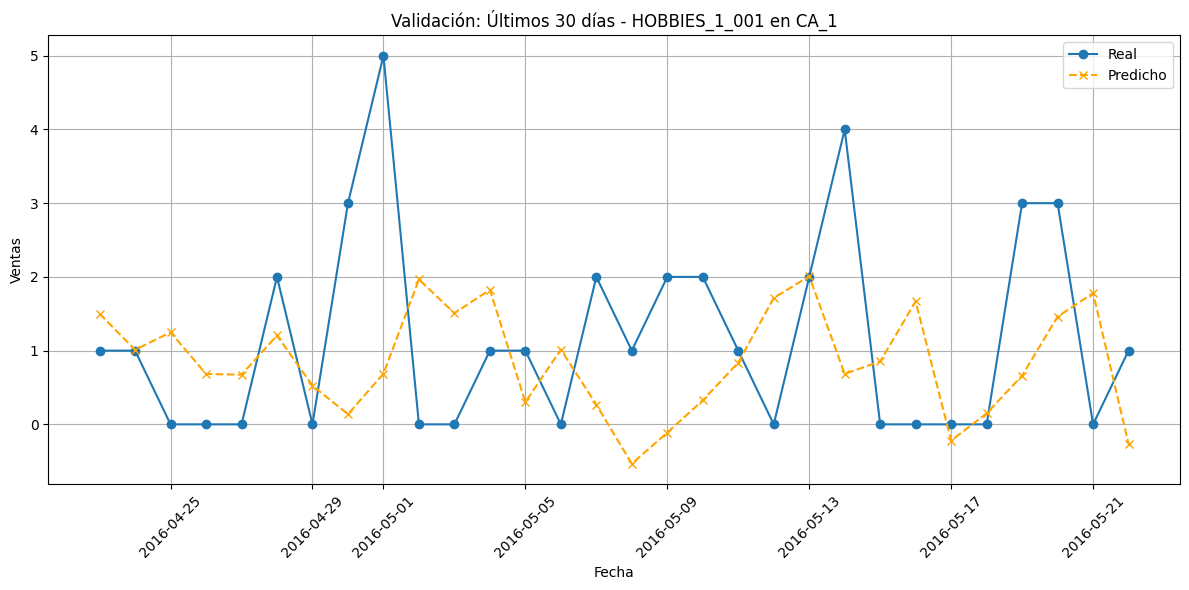

In [ ]:
# === Parámetros ===
ITEM_ID = 'HOBBIES_1_001'
STORE_ID = 'CA_1'
N_PRED = 30           # días a predecir
N_STEPS = 30          # ventana de input
EPOCHS = 500
BATCH_SIZE = 16

# === 1. Cargar y filtrar datos ===

current_dir = os.getcwd()
lstm_path = os.path.join(current_dir, "../data/csv_model/lstm_1p_10s_daily.csv")
df = pd.read_csv(lstm_path, parse_dates=['date'])
# Filtrar por tienda y producto
df_filtered = df[(df['item_id'] == ITEM_ID) & (df['store_id'] == STORE_ID)].copy()
# Ordenar por fecha
df_filtered = df_filtered.sort_values('date')
df_filtered.reset_index(drop=True, inplace=True)

# === 2. Preprocesamiento ===

sales = df_filtered['sales'].values.reshape(-1, 1)
# Escalado entre 0 y 1
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

# === 3. Dividir datos: entrenamiento y prueba para últimos 30 días ===

# Separar datos: entrenamiento hasta 30 días antes del final
train_data = sales_scaled[:-N_PRED]
test_data = sales_scaled[-(N_PRED + N_STEPS):]  # incluye la ventana necesaria para predecir

# Función para crear secuencias (ya la tienes, la volvemos a usar)
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train_data, N_STEPS)

# === 4. Definir y entrenar modelo LSTM ===

#Resulados aceptables, excepto r2_score. ## relu
model = Sequential([
    LSTM(64, activation='relu', input_shape=(N_STEPS, 1)),
    Dense(1)
])

## tanh
# model = Sequential([
#     LSTM(64, activation='tanh', return_sequences=True, input_shape=(N_STEPS, 1)),
#     Dropout(0.2),
#     LSTM(32, activation='tanh'),
#     Dense(1)
# ])

# model = Sequential([
#     LSTM(64, activation='tanh', return_sequences=True, input_shape=(N_STEPS, 1)),
#     LSTM(32, activation='tanh'),
#     Dense(16, activation='relu'),
#     Dense(1)
# ])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# === 5. Predecir los últimos 30 días reales ===

# Usamos la última ventana del conjunto de prueba
input_seq = test_data[:N_STEPS].reshape(1, N_STEPS, 1)

predictions = []
for _ in range(N_PRED):
    next_pred = model.predict(input_seq)[0][0]
    predictions.append(next_pred)
    # Desplazamos la secuencia para incluir la predicción
    input_seq = np.append(input_seq[:, 1:, :], [[[next_pred]]], axis=1)

# Invertimos el escalado
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# === 6. Mostrar resultados comparando con datos reales ===

# Fechas reales de los últimos 30 días
real_dates = df_filtered['date'].iloc[-N_PRED:]
real_values = df_filtered['sales'].iloc[-N_PRED:].values

# Visualizar
plt.figure(figsize=(12,6))
plt.plot(real_dates, real_values, label='Real', marker='o')
plt.plot(real_dates, predictions, label='Predicho', linestyle='--', color='orange', marker='x')
plt.title(f'Validación: Últimos {N_PRED} días - {ITEM_ID} en {STORE_ID}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Guardar comparación
comparison_df = pd.DataFrame({
    'date': real_dates,
    'real_sales': real_values,
    'predicted_sales': predictions
})
comparison_df.to_csv(f'validation_last_{N_PRED}_days_{ITEM_ID}_{STORE_ID}.csv', index=False)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular métricas
mse = mean_squared_error(real_values, predictions)
mae = mean_absolute_error(real_values, predictions)
r2 = r2_score(real_values, predictions)

# Mostrar en pantalla
print(f"📊 Evaluación del modelo:")
print(f"➡️  MSE:  {mse:.2f}")
print(f"➡️  MAE:  {mae:.2f}")
print(f"➡️  R²:   {r2:.4f}")

📊 Evaluación del modelo:
➡️  MSE:  2.72
➡️  MAE:  1.32
➡️  R²:   -0.5051
